In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack
import pygrib

### this program filter out the periods shorter than 2 and larger than 6 days

In [2]:
def filter_time(signal, p_min, p_max, dt):
    
    
    nyquist = 0.5 * dt
    min_fs = 1/p_max/nyquist
    max_fs = 1/p_min/nyquist
    
    freq = np.fft.fftfreq(nt, d=dt)
    
    f_signal = fftpack.fft(signal)
    
    #Preparing the kernel
    filter_kernel = np.zeros(nt)   # valid frequencies  
    filter_kernel[(np.abs(freq) < min_fs) | (np.abs(freq) > max_fs) ] = 1.0 # invalid frequencies
    
    f_signal_filtered = f_signal * filter_kernel# Compute the filtered signal by applying the kernel
    
    signal_filtered = np.real(fftpack.ifft(f_signal_filtered))
    
    # Inverse Fourier transform to get the filtered signal
    signal_filtered = np.fft.ifft(f_signal_filtered).real
    
    return signal_filtered

In [3]:
#read data
ds = xr.open_dataset('198511_500.grb', engine='cfgrib')

gh = ds['gh'] #geopotential height
lat = ds['latitude'].data
lon = ds['longitude'].data
time = ds['time']
#%%
n_lon = len(lon)
n_lat = len(lat)
nt = len(gh)

time_s = np.linspace(1, nt, nt)
dt = time_s[1]-time_s[0] # day

p_min = 2 # day
p_max = 6 # day

gh_filtered = np.empty_like(gh)

for i in range(n_lon):
    for j in range (n_lat):
        gh_filtered[:,j,i] = filter_time(gh[:,j,i].data, p_min, p_max, dt)



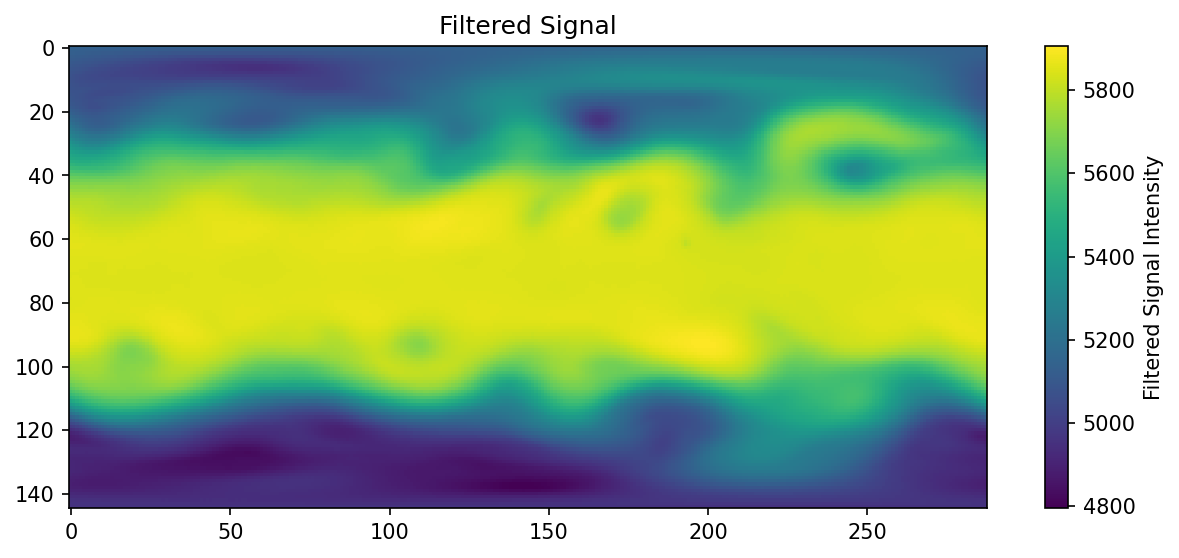

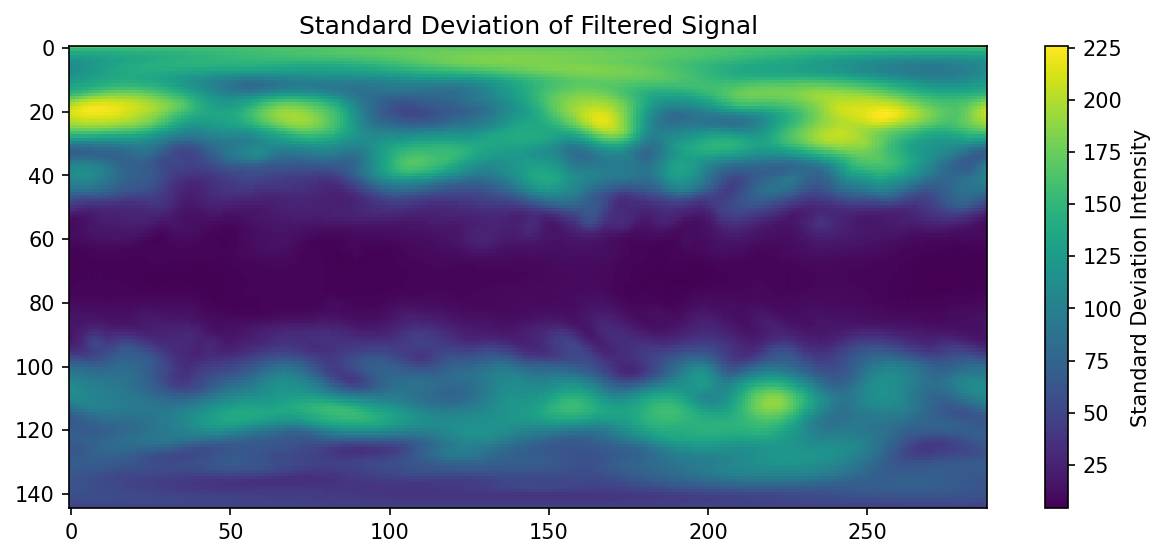

In [5]:
# plot the data as imshow

fig1, ax1 = plt.subplots(figsize=(10, 4), dpi=150)
im1 = ax1.imshow(gh_filtered[1, ...])
fig1.colorbar(im1, ax=ax1, orientation='vertical', label='Filtered Signal Intensity')
ax1.set_title('Filtered Signal')
fig1.savefig('./outputs/filtered_signal.png', bbox_inches='tight')


fig2, ax2 = plt.subplots(figsize=(10, 4), dpi=150)
gh_filtered_sdt = gh_filtered.reshape(nt, n_lon * n_lat).std(axis=0).reshape(n_lat, n_lon)
im2 = ax2.imshow(gh_filtered_sdt)
fig2.colorbar(im2, ax=ax2, orientation='vertical', label='Standard Deviation Intensity')
ax2.set_title('Standard Deviation of Filtered Signal')
fig2.savefig('./outputs/filtered_signal_std.png', bbox_inches='tight')


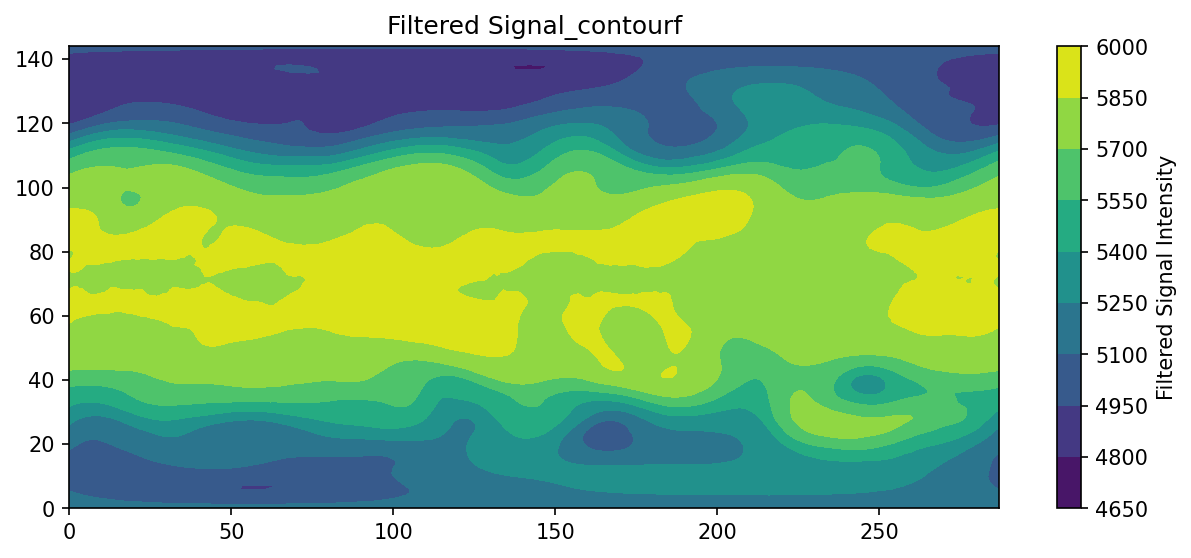

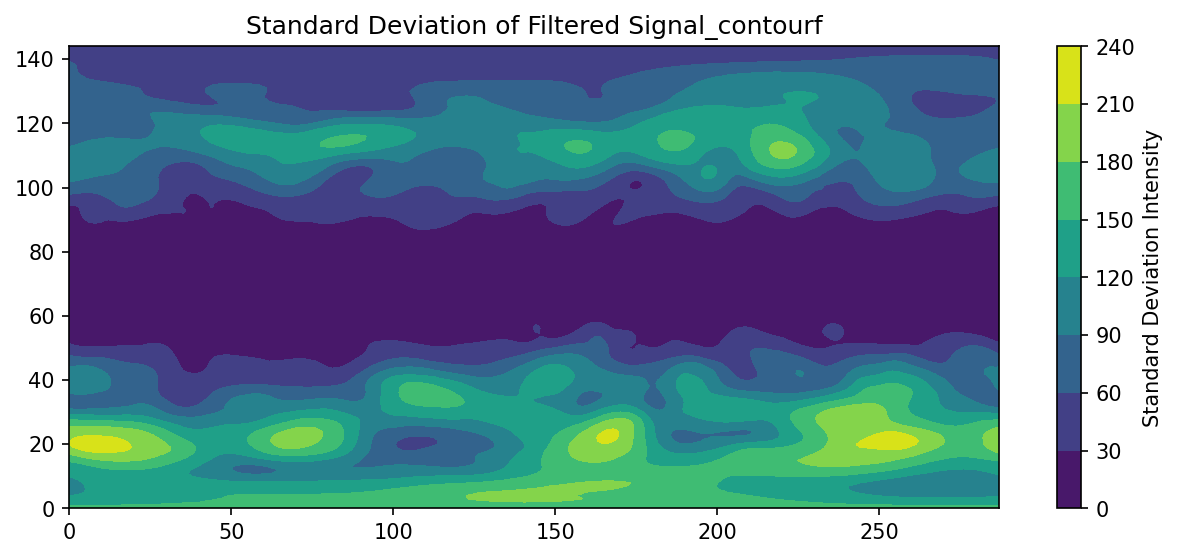

In [7]:
# plot the data as contourf

fig1, ax1 = plt.subplots(figsize=(10, 4), dpi=150)
im1 = ax1.contourf(gh_filtered[1, ...])
fig1.colorbar(im1, ax=ax1, orientation='vertical', label='Filtered Signal Intensity')
ax1.set_title('Filtered Signal_contourf')
fig1.savefig('./outputs/filtered_signal_contourf.png', bbox_inches='tight')


fig2, ax2 = plt.subplots(figsize=(10, 4), dpi=150)
gh_filtered_sdt = gh_filtered.reshape(nt, n_lon * n_lat).std(axis=0).reshape(n_lat, n_lon)
im2 = ax2.contourf(gh_filtered_sdt)
fig2.colorbar(im2, ax=ax2, orientation='vertical', label='Standard Deviation Intensity')
ax2.set_title('Standard Deviation of Filtered Signal_contourf')
fig2.savefig('./outputs/filtered_signal_std_contourf.png', bbox_inches='tight')


In [8]:

 #%% to write again as grib like the original data


output_grib_file = open('./outputs/output.grb', 'wb')

# Open the original GRIB file to get the metadata
grib_file = pygrib.open('198511_500.grb')
i=0
for msg in grib_file:
    # print(msg.values,i)
    # Get original data
    original_data = msg.values

    # Replace original data with your new data
    # (Ensure that the shapes match)
    if original_data.shape == gh_filtered[i,...].shape:
        msg.values = gh_filtered[i,...]
    else:
        print("Shape mismatch; cannot replace data.")
        continue

    # Write the modified message to the output GRIB file
    output_grib_file.write(msg.tostring())
    i=i+1

# Close the files
output_grib_file.close()
grib_file.close()
#%%
print(xr.open_dataset('./outputs/output.grb', engine='cfgrib')) # control the output


<xarray.Dataset> Size: 5MB
Dimensions:        (time: 30, latitude: 145, longitude: 288)
Coordinates:
  * time           (time) datetime64[ns] 240B 1985-11-01 ... 1985-11-30
    step           timedelta64[ns] 8B ...
    isobaricInhPa  float64 8B ...
  * latitude       (latitude) float64 1kB 90.0 88.75 87.5 ... -87.5 -88.75 -90.0
  * longitude      (longitude) float64 2kB 0.0 1.25 2.5 ... 356.2 357.5 358.8
    valid_time     (time) datetime64[ns] 240B ...
Data variables:
    gh             (time, latitude, longitude) float32 5MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             rjtd
    GRIB_centreDescription:  Japanese Meteorological Agency - Tokyo
    GRIB_subCentre:          241
    Conventions:             CF-1.7
    institution:             Japanese Meteorological Agency - Tokyo
    history:                 2024-08-10T11:34 GRIB to CDM+CF via cfgrib-0.9.1...
